In [1]:
import logging
import torch
from torch import nn
from torch.distributions import constraints
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, TraceEnum_ELBO, Trace_ELBO, config_enumerate, infer_discrete
from pyro.optim import ClippedAdam
from pyro.ops.indexing import Vindex
import os
import nltk
import collections
import re
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import time
import pickle

<h2> Data pre-processing </h2>

In [2]:
#Data Assimilation
knowngrp = collections.deque()
data = collections.deque()
for root, folder, files in os.walk("./data/summaries"):
    if len(folder)!=0: continue
    for file in files:
        txt = " ".join(open(root+"/"+file, "r").readlines())
        data.append(txt)
        knowngrp.append(root.split("/")[-1])
origdata = data.copy()

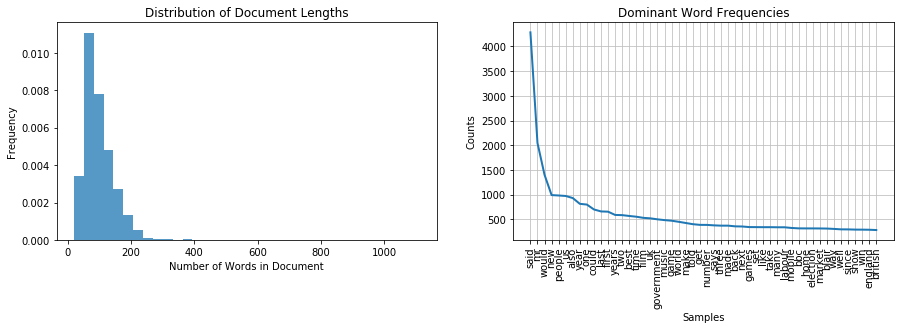

In [3]:
#Data Cleaning
en_stop = set(nltk.corpus.stopwords.words('english'))
for i in range(len(data)):
    txt = re.sub("\."," \. ",data[i])
    txt = re.sub("[^a-zA-Z0-9 ]","",txt)
    txt = txt.lower().split()
    data[i] = [elem for elem in txt if elem not in en_stop and len(elem)>1]
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
lengths = [len(txt) for txt in data]
pd.Series(lengths).plot(kind="hist",bins=35,alpha=0.75, density=True)
plt.xlabel("Number of Words in Document")
plt.title("Distribution of Document Lengths")
plt.subplot(1,2,2)
plt.title("Dominant Word Frequencies")
nltk.probability.FreqDist([word for txt in data for word in txt]).plot(50)
plt.show()

In [4]:
#Sample fewer articles (50 from each known group) and enforce a max-len of 150
np.random.seed(1)
vals = np.unique(knowngrp)
arr = np.zeros(len(vals)*50, dtype=np.int64)
for i in range(len(vals)):
    chc = np.random.choice(np.where(np.array(knowngrp)==vals[i])[0], 50)
    arr[(i*50):((i+1)*50)] = chc
knowngrp = np.array(knowngrp)[arr]
data = [data[i] for i in arr]

In [5]:
#Final Wrangling for DESIGN 1
wordnum, worddict = 0, {}
for i in range(len(data)):
    for j in range(len(data[i])):
        if worddict.get(data[i][j],None) is None:
            worddict[data[i][j]] = wordnum
            wordnum+=1
        data[i][j] = worddict[data[i][j]]
    data[i] = torch.tensor(data[i])

In [ ]:
#Final Wrangling for DESIGN 2
for i in range(len(data)):
    if len(data[i])>150:
        data[i] = np.random.choice(data[i],150,replace=False)
    else:
        data[i] = np.concatenate([np.array(data[i]), np.random.choice(data[i],150-len(data[i]),replace=True)])
wordnum, worddict = 0, {}
for i in range(len(data)):
    for j in range(len(data[i])):
        if worddict.get(data[i][j],None) is None:
            worddict[data[i][j]] = wordnum
            wordnum+=1
        data[i][j] = worddict[data[i][j]]
data = np.array(data, dtype=np.int64)
data = torch.tensor(data)
data.shape

In [6]:
revdict = {}
for word in worddict.keys():
    revdict[worddict[word]] = word

<h2> Pyro Model Design 1 - Sequential Plating

In [7]:
def model(data, N, K, V):
    eta = torch.ones(K,V)/V
    with pyro.plate('topic_loop',K):
        beta = pyro.sample('vocab_beta', dist.Dirichlet(eta))
    alpha = torch.ones(N,K)/K
    for n in pyro.plate('document_loop',N):
        theta = pyro.sample('document_topic_{n}'.format(n=n), dist.Dirichlet(alpha[n]))
        with pyro.plate('word_loop_{n}'.format(n=n), len(data[n])):
            z = pyro.sample('z_{n}'.format(n=n), dist.Categorical(theta))
            pyro.sample('wrd_{n}'.format(n=n), dist.Categorical(beta[z]), obs=data[n])

In [8]:
def guide(data, N, K, V):
    etaparam = pyro.param('eta_param', torch.ones(K,V)/V, constraint=constraints.positive)
    with pyro.plate('topic_loop',K):
        beta = pyro.sample('vocab_beta', dist.Dirichlet(etaparam))
    alphaparam = pyro.param('alpha_param', torch.ones(N,K)/K, constraint=constraints.positive)
    for n in pyro.plate('document_loop', N):
        theta = pyro.sample('document_topic_{n}'.format(n=n), dist.Dirichlet(alphaparam[n]))
        with pyro.plate('word_loop_{n}'.format(n=n), len(data[n])):
            z = pyro.sample('z_{n}'.format(n=n), dist.Categorical(theta))

In [ ]:
adam_params = {"lr":0.01, "betas":(0.90,0.999)}
optimizer = pyro.optim.Adam(adam_params)
elbo = Trace_ELBO(max_plate_nesting=2)
pyro.clear_param_store()
svi = SVI(model, guide, optimizer, loss=elbo)
losses = collections.deque()

In [9]:
start = time.time()
for i in range(5000):
    loss = svi.step(data, len(data), 5, len(worddict))
    losses.append(loss)
    if (i+1)%500==0:
        print("Epoch Update at Step "+str(i+1)+" with loss "+str(round(loss,5))+" in "+
              str(round(time.time()-start))+" seconds")
pyro.get_param_store().save("./ldapyro.cst")
pickle.dump(losses,open("./lossvec.pkl","wb"))

Epoch Update at Step 500 with loss 227771.79292 in 2924 seconds
Epoch Update at Step 1000 with loss 170004.14242 in 5750 seconds
Epoch Update at Step 1500 with loss 151191.89084 in 8731 seconds
Epoch Update at Step 2000 with loss 136458.01605 in 11501 seconds
Epoch Update at Step 2500 with loss 118947.0656 in 14239 seconds
Epoch Update at Step 3000 with loss 101381.83489 in 17187 seconds
Epoch Update at Step 3500 with loss 79686.59377 in 20247 seconds
Epoch Update at Step 4000 with loss 55980.68299 in 23232 seconds
Epoch Update at Step 4500 with loss 27533.09118 in 26185 seconds
Epoch Update at Step 5000 with loss -4738.2276 in 28943 seconds


In [10]:
pickle.dump(losses,open("./lossvec.pkl","wb"))

In [11]:
for i in range(5000,7000):
    loss = svi.step(data, len(data), 5, len(worddict))
    losses.append(loss)
    if (i+1)%500==0:
        print("Epoch Update at Step "+str(i+1)+" with loss "+str(round(loss,5))+" in "+
              str(round(time.time()-start))+" seconds")
pyro.get_param_store().save("./ldapyro.cst")
pickle.dump(losses,open("./lossvec.pkl","wb"))

Epoch Update at Step 5500 with loss -44223.85554 in 31703 seconds
Epoch Update at Step 6000 with loss -91722.61846 in 34576 seconds
Epoch Update at Step 6500 with loss -149386.37372 in 37431 seconds
Epoch Update at Step 7000 with loss -219532.53136 in 40372 seconds


<h2>Pyro Model Design 2 - Vectorized Plating with Enumeration

In [6]:
def model(N, K, V, LN, data=None):
    eta = torch.ones(K,V)/V
    with pyro.plate('topic_loop',K):
        beta = pyro.sample('vocab_beta', dist.Dirichlet(eta))
    alpha = torch.ones(N,K)/K
    with pyro.plate('document_loop',N):
        theta = pyro.sample('document_topic', dist.Dirichlet(alpha))
        with pyro.plate('word_loop', LN):
            z = pyro.sample('z', dist.Categorical(theta), infer={"enumerate": "parallel"})
            w = pyro.sample('wrd', dist.Categorical(Vindex(beta)[z]), obs=data)

In [7]:
def guide(N, K, V, LN, data=None):
    etaparam = pyro.param('eta_param', torch.ones(K,V)/V, constraint=constraints.positive)
    with pyro.plate('topic_loop',K):
        beta = pyro.sample('vocab_beta', dist.Dirichlet(etaparam))
    alphaparam = pyro.param('alpha_param', torch.ones(N,K)/K, constraint=constraints.positive)
    with pyro.plate('document_loop', N):
        theta = pyro.sample('document_topic', dist.Dirichlet(alphaparam))

In [ ]:
adam_params = {"lr":0.01, "betas":(0.90,0.999)}
optimizer = pyro.optim.Adam(adam_params)
elbo = TraceEnum_ELBO(max_plate_nesting=2)
pyro.clear_param_store()
svi = SVI(model, guide, optimizer, loss=elbo)
losses = collections.deque()
start = time.time()
for i in range(3):
    loss = svi.step(250,5,len(worddict),150,data.T)
    losses.append(loss)
    #if (i+1)%100==0:
    #    print("Epoch Update at Step "+str(i+1)+" with loss "+str(round(loss,5))+" in "+
    #          str(round(time.time()-start))+" seconds")
print(time.time()-start)
#pyro.get_param_store().save("./ldapyro1.cst")

<h2> Model Results </h2>

In [12]:
#Open the relevant param-store and loss vector for the design to be visualized
pyro.get_param_store().load("./ldapyro.cst")
losses = pickle.load(open("./lossvec.pkl","rb"))

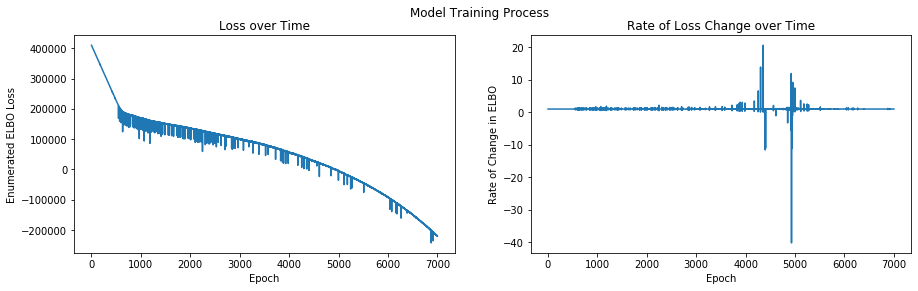

In [13]:
#Loss visualizations
plt.figure(figsize=(15,4))
plt.suptitle("Model Training Process")
plt.subplot(1,2,1)
losses = pd.Series(losses, index=np.arange(1,len(losses)+1))
losses.plot()
plt.xlabel("Epoch")
plt.ylabel("Enumerated ELBO Loss")
plt.title("Loss over Time")
plt.subplot(1,2,2)
(losses/losses.shift(1)).dropna().plot()
plt.xlabel("Epoch")
plt.ylabel("Rate of Change in ELBO")
plt.title("Rate of Loss Change over Time")
plt.show()

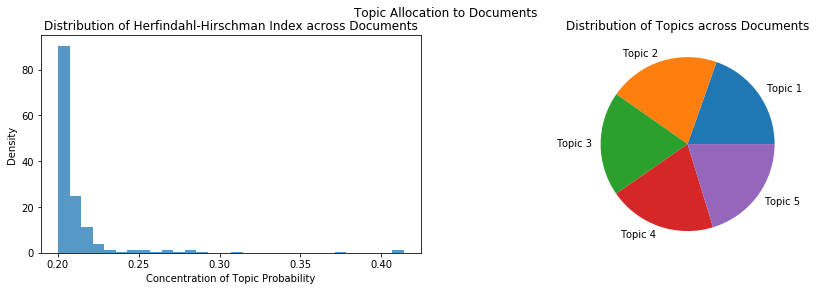

In [14]:
alpha = pyro.param('alpha_param').data.numpy()
#Apply softmax activation to convert logits to probabilities
alpha = np.exp(alpha)
alpha = alpha/np.sum(alpha, axis=1).reshape(-1,1)
plt.figure(figsize=(15,4))
plt.suptitle("Topic Allocation to Documents")
plt.subplot(1,2,1)
plt.hist(np.sum(alpha**2, axis=1), bins=30, alpha=0.75, density=True)
plt.ylabel("Density")
plt.xlabel("Concentration of Topic Probability")
plt.title("Distribution of Herfindahl-Hirschman Index across Documents")
plt.subplot(1,2,2)
plt.pie(np.sum(alpha,axis=0), labels=["Topic 1","Topic 2","Topic 3","Topic 4","Topic 5"])
plt.title("Distribution of Topics across Documents")
plt.show()

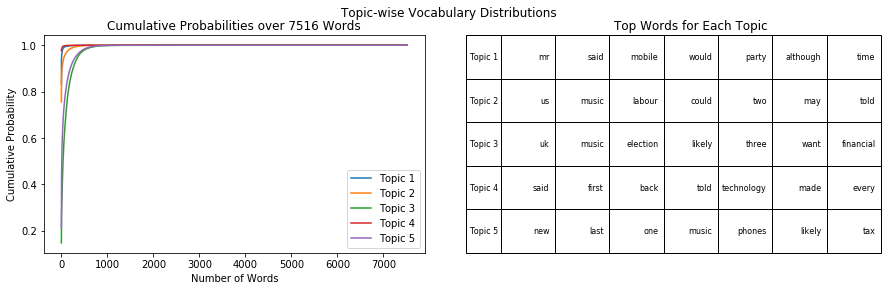

In [15]:
plt.figure(figsize=(15,4))
plt.suptitle("Topic-wise Vocabulary Distributions")
eta = pyro.param('eta_param').data.numpy()
eta = eta/np.sum(eta,axis=1).reshape(-1,1)
plt.subplot(1,2,1)
for i in range(5):
    pd.Series(np.cumsum(np.sort(eta[i])[::-1]), index=np.arange(1,eta.shape[1]+1)).plot(label="Topic "+str(i+1))
plt.legend(loc="best")
plt.xlabel("Number of Words")
plt.ylabel("Cumulative Probability")
plt.title("Cumulative Probabilities over 7516 Words")
plt.subplot(1,2,2)
topwords = np.zeros((5,7), dtype="<U25")
for i in range(5):
    topwords[i] = [revdict[i] for i in np.argsort(eta[i])[::-1][:7]]
plt.table(topwords, rowLabels=["Topic 1","Topic 2","Topic 3","Topic 4","Topic 5"], bbox=[0,0,1,1])
plt.axis("off")
plt.title("Top Words for Each Topic")
plt.show()

In [17]:
#Visualize two similarly grouped documents
group = 0 #Range [0-4]
topart = np.argsort(alpha[:,group])[-2:]
print("FIRST ARTICLE:")
print(origdata[topart[0]])
print()
print("SECOND ARTICLE:")
print(origdata[topart[1]])

FIRST ARTICLE:
The films look well transferred to DVD, though none has extras.It's a universal rule that a film can either be a superhero special effects extravaganza or it can be good.This disc covers those special effects enough but as just one part of a detailed look at the film.The other universal rule is that DVDs of superhero films will have Making Of features only about the effects.This set has the first season of Buck (Gil Gerard) and Wilma's (Erin Gray) tongue-in-cheek adventures and it's all as camp and gaudy as you remember.The US DVD has this and the more po-faced second season - and you can import it for just about the same price.The bigger omission, though, is that there are no extras.Sometimes quality comes in bulk: this set contains no less than 34 John Wayne films ranging from the Westerns and war movies to The Quiet Man.

SECOND ARTICLE:
The show's highest audience came at Christmas 1986, when more than 30 million tuned in to see Den, played by Leslie Grantham, hand d